# Ensemble Classifiers: Reduced Featureset
---
Reduced featureset (18 features): ['illday', 'rash', 'redeyes', 'redplt', 'clnode',
		'redhands', 'pwbc', 'ppolys', 'pbands', 'plymphs', 'pmonos',
		'peos', 'pesr', 'pcrp', 'pplts', 'palt', 'pggt', 'zhemo']

### Pre-Training Setup (Load Reduced-Features Data)

In [1]:
import sys
sys.path.append('../') # Make parent folder visible
import numpy as np
from scipy.stats import randint

from sklearn import svm, linear_model, neighbors, ensemble, naive_bayes, \
    neural_network, tree, gaussian_process, discriminant_analysis
    
import matplotlib.pyplot as plt

from preprocess import load_data
from model_helpers.models import compute_confusion, explain_confusion, get_fc_kd_thresholds, \
    test_model, plot_cv_roc_curves, ScikitModel

In [2]:
x, y, ids = load_data.load_expanded(one_hot=False, fill_mode='mean', reduced_features=True)

### Test out Candidate Learners

In [3]:
# SVM
svm_model = ScikitModel(svm.SVC(probability=True), 
                       {
                           'C': np.logspace(-3, 3, 100),
                           'gamma': np.logspace(-3, 3, 100),
                           'kernel': ['linear', 'rbf', 'poly']
                       },
                       random_search=True,
                       n_iter=100,
                       scoring='roc_auc',
                       verbose=True)
svm_rocs = test_model(svm_model,
                      x, y,
                      allow_indeterminates=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.6min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.021544346900318846, 'C': 0.53366992312063122}
Best score:  0.975324672745
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.6min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.001, 'C': 81.113083078968728}
Best score:  0.968569314364
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.4min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.0081113083078968723, 'C': 2.8480358684358018}
Best score:  0.975049399227
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  9.3min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.024770763559917114, 'C': 2.8480358684358018}
Best score:  0.968561034692
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.5min finished


Best params:  {'kernel': 'rbf', 'gamma': 0.0030538555088334154, 'C': 4.3287612810830618}
Best score:  0.971760876122
CV Confusion:  [(106, 7, 5, 143, 12, 16), (112, 7, 5, 150, 6, 9), (91, 6, 4, 122, 27, 38), (113, 8, 5, 157, 3, 2), (88, 7, 4, 146, 29, 14)]
Best CV scores:  [ 0.9753  0.9686  0.975   0.9686  0.9718]
Avg best scores:  0.97185305943
FC Classified as FC: 510, (93.5779816514 %)
FC Classified as KD: 35, (6.42201834862 %)
KD Classified as FC: 23, (3.10391363023 %)
KD Classified as KD: 718, (96.8960863698 %)
FC left indeterminate: 77
KD left indeterminate: 79


In [4]:
# Logistic Regression
lr_model = ScikitModel(linear_model.LogisticRegression(), 
                       params={
                           'C': np.logspace(-2, 2, 5)
                       },
                       random_search=False,
                       scoring='roc_auc',
                       verbose=True)
lr_rocs = test_model(lr_model,
                     x, y,
                     allow_indeterminates=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Best params:  {'C': 0.01}
Best score:  0.974585786227
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.967782408876


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 100.0}
Best score:  0.974463743231


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.968702228605


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:  {'C': 0.01}
Best score:  0.971804104121


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


CV Confusion:  [(105, 7, 5, 140, 13, 19), (118, 8, 6, 159, 0, 0), (95, 6, 5, 114, 23, 45), (114, 8, 6, 156, 2, 2), (92, 7, 4, 147, 25, 13)]
Best CV scores:  [ 0.9746  0.9678  0.9745  0.9687  0.9718]
Avg best scores:  0.971467654212
FC Classified as FC: 524, (93.5714285714 %)
FC Classified as KD: 36, (6.42857142857 %)
KD Classified as FC: 26, (3.50404312668 %)
KD Classified as KD: 716, (96.4959568733 %)
FC left indeterminate: 63
KD left indeterminate: 79


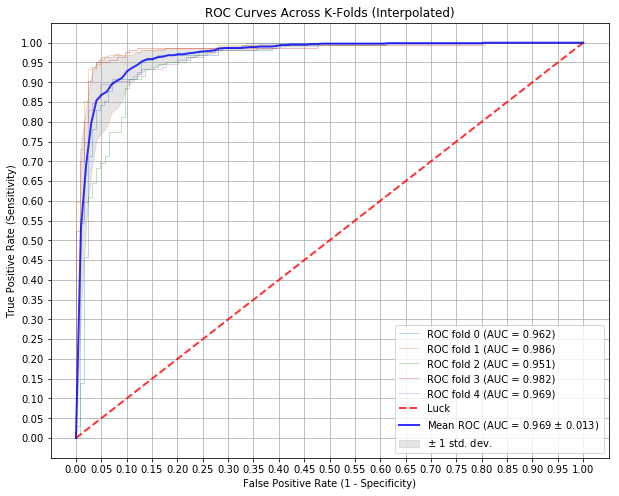

In [5]:
plot_cv_roc_curves(lr_rocs)

In [6]:
# Random Forest
rf_model = ScikitModel(ensemble.RandomForestClassifier(), 
                       params={
                           'n_estimators': randint(10, 500),
                           'max_features': randint(3, 15),
                           'min_samples_split': randint(2, 50),
                           'min_samples_leaf': randint(1, 50)
                       },
                       random_search=True,
                       n_iter=250,
                       scoring='roc_auc',
                       verbose=True)
rf_rocs = test_model(rf_model,
                     x, y,
                     allow_indeterminates=True)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 13.4min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 41, 'n_estimators': 144}
Best score:  0.97329764345
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.7min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 342}
Best score:  0.969909034533
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 15.7min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 22, 'n_estimators': 167}
Best score:  0.971406444083
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 15.1min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 355}
Best score:  0.969477628495
Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 12.1min finished


Best params:  {'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 21, 'n_estimators': 220}
Best score:  0.973444333261
CV Confusion:  [(102, 7, 5, 134, 16, 25), (115, 8, 6, 155, 2, 3), (87, 7, 4, 135, 30, 25), (115, 8, 6, 156, 1, 2), (96, 7, 5, 141, 21, 18)]
Best CV scores:  [ 0.9733  0.9699  0.9714  0.9695  0.9734]
Avg best scores:  0.971507016764
FC Classified as FC: 515, (93.2971014493 %)
FC Classified as KD: 37, (6.70289855072 %)
KD Classified as FC: 26, (3.48058902276 %)
KD Classified as KD: 721, (96.5194109772 %)
FC left indeterminate: 70
KD left indeterminate: 73


## Sklearn Ensemble Model

In [7]:
# Grid search params
clf1 = svm.SVC(probability=True)
clf2 = linear_model.LogisticRegression()

eclf = ensemble.VotingClassifier(
    estimators=[('svm', clf1), ('lr', clf2)],
    voting='soft')

params = {
    'svm__C': np.logspace(-3, 2, 100),
    'svm__gamma': np.logspace(-3, 2, 100),
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'lr__C': np.logspace(-3, 2, 100)
}

# Test model! 5-fold CV with hyperparameter optimization
clf = ScikitModel(
    eclf,
    params,
    random_search=True, 
    n_iter=100, 
    verbose=True)

ensemble_rocs = test_model(clf, x, y, allow_indeterminates=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.011497569953977356, 'svm__C': 1.2045035402587825, 'lr__C': 0.010235310218990263}
Best score:  0.976073810542
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.3min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.052140082879996844, 'svm__C': 1.3530477745798062, 'lr__C': 0.01291549665014884}
Best score:  0.969889502334
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.2min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.010235310218990263, 'svm__C': 0.95454845666183374, 'lr__C': 0.33516026509388408}
Best score:  0.975109571378
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.0031992671377973846, 'svm__C': 39.442060594376564, 'lr__C': 0.0031992671377973846}
Best score:  0.970079138856
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.5min finished


Best params:  {'svm__kernel': 'rbf', 'svm__gamma': 0.0040370172585965534, 'svm__C': 0.26560877829466867, 'lr__C': 35.111917342151273}
Best score:  0.97234128163
CV Confusion:  [(106, 7, 5, 145, 12, 14), (114, 8, 6, 157, 3, 1), (92, 6, 4, 121, 26, 39), (115, 8, 6, 156, 1, 2), (88, 7, 4, 147, 29, 13)]
Best CV scores:  [ 0.9761  0.9699  0.9751  0.9701  0.9723]
Avg best scores:  0.972698660948
FC Classified as FC: 515, (93.4664246824 %)
FC Classified as KD: 36, (6.5335753176 %)
KD Classified as FC: 25, (3.32889480692 %)
KD Classified as KD: 726, (96.6711051931 %)
FC left indeterminate: 71
KD left indeterminate: 69


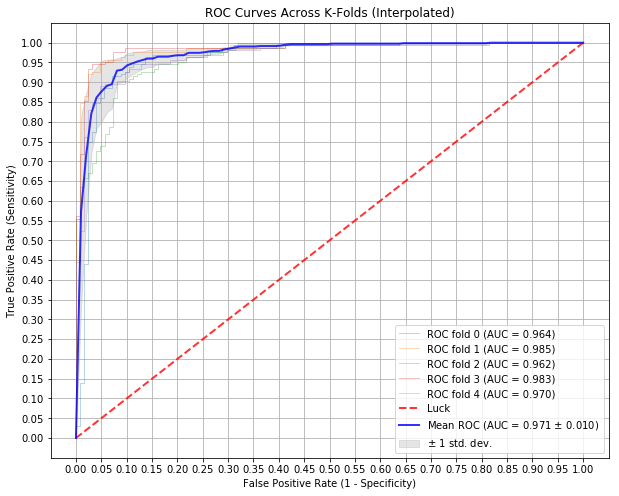

In [8]:
plot_cv_roc_curves(ensemble_rocs)